## ewf-wfp-02-01-03 - Long Term Averages of Land Surface Temperature Time Series

Long Term Averages of Land Surface Temperature Time Series

---

### <a name="service">Service definition

In [50]:
service = dict([('title', 'Long Term Averages of Land Surface Temperature Time Series'),
                ('abstract', 'Long Term Averages of Land Surface Temperature Time Series'),
                ('id', 'ewf-wfp-02-01-03')])

### <a name="parameter">Parameter Definition 

In [51]:
N_1 = dict([('id', 'N_1'),
                          ('value', 'False'),
                          ('title', 'No Aggregation'),
                          ('abstract', 'No aggregation')])

In [52]:
N_3 = dict([('id', 'N_3'),
                          ('value', 'True'),
                          ('title', '30 Day Aggregation'),
                          ('abstract', 'Get a 30 day aggregation')])

In [53]:
N_6 = dict([('id', 'N_6'),
                          ('value', 'False'),
                          ('title', '60 Day Aggregation'),
                          ('abstract', 'Get a 30 day aggregation')])

In [54]:
 N_9 = dict([('id', 'N_9'),
                          ('value', 'False'),
                          ('title', '90 Day Aggregation'),
                          ('abstract', 'Get a 90 day aggregation')])

In [55]:
 N_12 = dict([('id', 'N_12'),
                          ('value', 'False'),
                          ('title', '120 Day Aggregation'),
                          ('abstract', 'Get a 120 day aggregation')])

In [56]:
 N_15 = dict([('id', 'N_15'),
                          ('value', 'False'),
                          ('title', '150 Day Aggregation'),
                          ('abstract', 'Get a 150 day aggregation')])

In [57]:
 N_18 = dict([('id', 'N_18'),
                          ('value', 'False'),
                          ('title', '180 Day Aggregation'),
                          ('abstract', 'Get a 180 day aggregation')])

In [58]:
 N_27 = dict([('id', 'N_27'),
                          ('value', 'False'),
                          ('title', '270 Day Aggregation'),
                          ('abstract', 'Get a 270 day aggregation')])

In [59]:
 N_36 = dict([('id', 'N_36'),
                          ('value', 'False'),
                          ('title', '360 Day Aggregation'),
                          ('abstract', 'Get a 360 day aggregation')])

In [60]:
regionOfInterest = dict([('id', 'regionOfInterest'),
                         ('value', 'POLYGON((11.5030755518998 -11.1141633706909,41.0343255518998 -11.1141633706909,41.0343255518998 -34.9763656693858,11.5030755518998 -34.9763656693858,11.5030755518998 -11.1141633706909))'),
                         ('title', 'WKT Polygon for the Region of Interest'),
                         ('abstract', 'Set the value of WKT Polygon')])

In [61]:
nameOfRegion = dict([('id', 'nameOfRegion'),
                     ('value', 'SouthernAfrica'),
                     ('title', 'Name of Region'),
                     ('abstract', 'Name of the region of interest'),
                     ('minOccurs', '1')])

### <a name="runtime">Runtime parameter definition

**Input identifiers**

This is the MDOIS stack of products' identifiers

In [62]:
# 2015, 2016, 2017
#averages
input_identifiers = ('LST_SouthernAfrica_N3_averages_2015-01-05_2015-01-25.tif', 'LST_SouthernAfrica_N3_averages_2016-01-05_2016-01-25.tif', 'LST_SouthernAfrica_N3_averages_2017-01-05_2017-01-25.tif')

#maxvalues
#input_identifiers = ('LST_SouthernAfrica_N3_maxvalues_2015-01-05_2015-01-25.tif', 'LST_SouthernAfrica_N3_maxvalues_2016-01-05_2016-01-25.tif', 'LST_SouthernAfrica_N3_maxvalues_2017-01-05_2017-01-25.tif')

**Input references**

This is the MODIS stack catalogue references

In [63]:
input_references = tuple(['https://catalog.terradue.com/modis/search?format=atom&uid={0}'.format(pid) for pid in input_identifiers])

**Data path**

This path defines where the data is staged-in. 

In [64]:
data_path = "/workspace/modis/outputs/output02"

**Aux folders**

In [65]:
output_folder = ''

In [66]:
temp_folder = 'temp'

#### Import Modules

In [67]:
import os
import shutil

import sys
import string
import numpy as np
from osgeo import gdal, ogr, osr
from shapely.wkt import loads

import pdb

#### Auxiliary vars

In [68]:
check_results = True

#### Auxiliary methods

In [69]:
def rm_cfolder(folder):
    #folder = '/path/to/folder'
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)
            
    
def get_metadata(filepath):
    ds = gdal.Open(filepath)
    projection = ds.GetProjection()
    geotransform = ds.GetGeoTransform()
    no_data_value = ds.GetRasterBand(1).GetNoDataValue()
    data_type = ds.GetRasterBand(1).DataType
    return projection, geotransform, no_data_value, data_type

#def matrix_sum(mat1, mat2, no_data_value=None):
#    if no_data_value is not None:
#        if not isinstance(mat1, int):
#            mat1[(mat1 == no_data_value)] = 0
#        if not isinstance(mat2, int):
#            mat2[(mat2 == no_data_value)] = 0
#    return mat1 + mat2




def matrix_sum(mat1, mat2, no_data_value=None):
    if no_data_value is not None:
        if not isinstance(mat1, int):
            mat1[(mat1 == no_data_value)] = 0
        if not isinstance(mat2, int):
            mat2[(mat2 == no_data_value)] = 0
            
            
    msum = mat1 + mat2
        
    msum[(mat1 == 0)] = 0
    msum[(mat2 == 0)] = 0
        
    return msum


def write_output_image(filepath, output_matrix, image_format, data_format, output_projection=None, output_geotransform=None, mask=None, no_data_value=None):
    
    driver = gdal.GetDriverByName(image_format)
    out_rows = np.size(output_matrix, 0)
    out_columns = np.size(output_matrix, 1)
    if mask is not None:
        output = driver.Create(filepath, out_columns, out_rows, 2, data_format)
        mask_band = output.GetRasterBand(2)
        mask_band.WriteArray(mask)
    else:
        output = driver.Create(filepath, out_columns, out_rows, 1, data_format)
        
    if output_projection is not None:
        output.SetProjection(output_projection)
    if output_geotransform is not None:
        output.SetGeoTransform(output_geotransform)
    
    raster_band = output.GetRasterBand(1)
    if no_data_value is not None:
        raster_band.SetNoDataValue(no_data_value)
    raster_band.WriteArray(output_matrix)
    gdal.Warp(filepath, output, format="GTiff", outputBoundsSRS='EPSG:4326', xRes=output_geotransform[1], yRes=-output_geotransform[5], targetAlignedPixels=True)
    
    output.FlushCache()
    
def calc_average(matrix_list, n_years):
    if not isinstance(matrix_list, list):
        return 0
    result = matrix_list[0]
    for i in range(1, n_years):
        result = matrix_sum(result, matrix_list[i])
    
    return np.divide(result, (n_years*1.00))

def get_matrix_list(image_list):
    mat_list = []
    for img in image_list:
        dataset = gdal.Open(img)
        product_array = dataset.GetRasterBand(1).ReadAsArray()
        mat_list.append(product_array)
        dataset = None
    return mat_list






def calc_lta(file_list):
    
    
    #file_list = []
    #if not os.path.isdir('tmp_data'):
    #    os.mkdir('tmp_data')
    #for enclosure in dataframe['enclosure'].tolist():
    #    filepath = 'tmp_data/' + os.path.basename(enclosure)
    #    status = get_product(enclosure, filepath)
    #    if status == 200:
    #        file_list.append(filepath)
    #print(file_list)
    
    
    
    if file_list:
        
        n_years = len(file_list)
        agr_period_matrix = get_matrix_list(file_list)
        print('Aggregations converted to matrices')
        lta = calc_average(agr_period_matrix, n_years)
        projection, geotransform, no_data_value, data_type = get_metadata(file_list[0])
        
        #for file_ in file_list:
        #    os.remove(file_)
        
        return lta, projection, geotransform, no_data_value, data_type
    
    else:
        return None, None, None
    
    
    

def write_output(temp_folder, lta, period_start_date, period_end_date, product_type, period_N, agr_type, region, projection, geo_transform, image_format, no_data_value, data_type):
    
    start_day_month = str(period_start_date.month) + '-' + str(period_start_date.day)
    end_day_month = str(period_end_date.month) + '-' + str(period_end_date.day)
    
    #path_name_ini = os.path.join(temp_folder, 'LTA_' )
    #output_name = temp_folder + '/' + 'LTA_' + product_type + '_' + region + '_' + str(period_N) + '_' + agr_type + '_' + start_day_month + '_' + end_day_month + '_' + str(period_start_date.year) + '_' + str(period_end_date.year) + '.tif'
    
    output_name = os.path.join(temp_folder, 'LTA_' + product_type + '_' + region + '_' + str(period_N) + '_' + agr_type + '_' + start_day_month + '_' + end_day_month + '_' + str(period_start_date.year) + '_' + str(period_end_date.year) + '.tif')
    
    write_output_image(output_name, lta, image_format, data_type, projection, geo_transform, no_data_value=no_data_value)
    return output_name

In [70]:
#Create folders
#if not os.path.isdir(data_path):
#    os.mkdir(data_path)

if len(output_folder) > 0:
    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)

if not os.path.isdir(temp_folder):
    os.mkdir(temp_folder)

#### Workflow

Compute Long Term Averages

In [71]:
# N time steps
nlist = [N_1['value'], N_3['value'], N_6['value'], N_9['value'], N_12['value'], N_15['value'], N_18['value'], N_27['value'], N_36['value']]
nlist = [n == 'True' for n in nlist]
nvalues = [1, 3, 6, 9, 12, 15, 18, 27, 36]

for bl,nv in zip(nlist, nvalues):
    
    # only works for selected N time steps
    if bl:
        
        N = nv
        file_list = [os.path.join(data_path, in_id.split('/')[-1]) for in_id in input_identifiers]
        file_list
        lta, projection, geotransform, no_data_value, data_type = calc_lta(file_list)


Aggregations converted to matrices


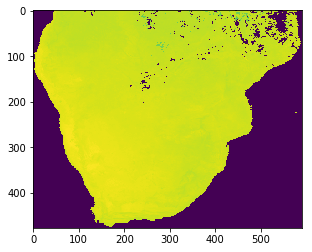

In [72]:
# CHECK
if check_results:
    
    import matplotlib
    import matplotlib.pyplot as plt

    fig = plt.figure()
    plt.imshow(lta)
    plt.show()

#### write output

In [47]:
import datetime as dt

filename = os.path.splitext(os.path.basename(file_list[0]))[0].split('_')

#startdate = '2015-01-05
#enddate = '2017-01-25'

startdate = filename[-2]
enddate = filename[-1]

startdate = dt.datetime.strptime(startdate, '%Y-%m-%d')
enddate = dt.datetime.strptime(enddate, '%Y-%m-%d')


agr = filename[3]
prod_type = filename[0]
N_value = filename[2]
region = filename[1]



if lta is not None:
    #pdb.set_trace()
    filename = write_output(output_folder, lta, startdate, enddate, prod_type, N_value, agr, region, projection, geotransform, 'GTiff', no_data_value, data_type)
    print(filename)
    #write_properties_file(match, filename) # TODO
    
#lta[310,210]

#startdate

LTA_LST_SouthernAfrica_N3_averages_1-5_1-25_2015_2015.tif


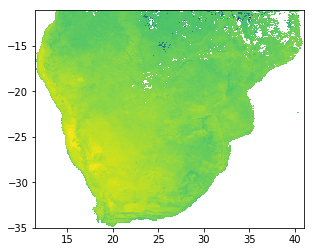

In [48]:
# CHECK

# CHECK
if check_results:
    
    import rasterio

    from rasterio.plot import show



    # Load data
    raster = filename

    data = rasterio.open(raster)

    show(data)

    #data = georasters.from_file(raster)

    # Plot data
    # data.plot()

#### Remove temporay files and folders

In [49]:
rm_cfolder(temp_folder)

os.rmdir(temp_folder)